In [1]:
from abc import abstractmethod
from typing import Dict, Callable

import random
import numpy as np
import torch
import jax

class DynamicalSystem:
    @abstractmethod
    def reset(self, seed: int=None):
        self._set_seed(seed)
        pass
    
    @abstractmethod
    def interact(self, control: float) -> float:
        """
        returns cost
        """
        ...
        pass
    
    def _set_seed(seed: int=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            jax.random.PRNGKey(seed)
            torch.manual_seed(seed)
        pass

In [2]:
from sklearn.datasets import fetch_california_housing, load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from testing.utils import device

class LinearRegression(DynamicalSystem):
    """
    GD over linear regression problem on one of the following datasets: `['california', 'diabetes', 'generated']`.
    Costs are measured in MSE loss values, and each interaction is one GD update.
    """
    def __init__(self, 
                 make_optimizer: Callable[[torch.nn.Module], torch.optim.Optimizer], 
                 dataset: str='diabetes',
                 eval_every: int=None,
                 probe_fns: Dict[str, Callable[[torch.nn.Parameter], float]]={},
                 seed: int=None):
        
        assert dataset in ['california', 'diabetes', 'generated']
        self._set_seed(seed)

        if dataset == 'california':
            X, y = fetch_california_housing(data_home='data', download_if_missing=True, return_X_y=True)
        elif dataset == 'diabetes':
            X, y = load_diabetes(return_X_y=True)
        elif dataset == 'generated':
            generation_args = {'n_features': 100, 'n_informative': 30, 'n_samples': 1000, 'noise': 0.1}
            X, y = make_regression(**generation_args)
        else:
            raise NotImplementedError(dataset)
        train_x, val_x, train_y, val_y = train_test_split(X, y)
        self.train_x = torch.FloatTensor(train_x, device=device),  
        self.train_y = torch.FloatTensor(train_y, device=device).reshape(-1, 1)
        self.val_x = torch.FloatTensor(val_x, device=device)
        self.val_y = torch.FloatTensor(val_y, device=device).reshape(-1, 1)
        
        self.model = torch.nn.Linear(X.shape[1], 1).float()
        self.opt = make_optimizer(self.model)
        self.model.train().to(device)
        
        # stats to keep track of
        self.t = 0
        self.eval_every = eval_every
        self.stats = {'train_losses': {},
                      'val_losses': {},
                      'lrs': {},
                      'momenta': {}}
        self.probe_fns = probe_fns
        for k in self.probe_fns.keys():
            self.stats[k] = {}
        self.last_loss = 0           
        if hasattr(self.opt, 'add_closure_func'):
            self.opt.add_closure_func(lambda: self.last_loss)
    
    def interact(self, _) -> float:
        # train step
        self.opt.zero_grad()
        train_loss = torch.nn.functional.mse_loss(self.model(self.train_x), self.train_y)
        train_loss.backward()
        train_loss = train_loss.item()
        self.last_loss = train_loss
        self.opt.step()
        
        # probe and cache desired quantities
        self.stats['train_losses'][self.t] = train_loss
        try:
            lr = self.opt.param_groups[0]['lr']
            momentum = self.opt.param_groups[0]['momentum']
            self.stats['lrs'][self.t] = lr if not hasattr(lr, 'item') else lr.item()
            self.stats['momenta'][self.t] = momentum if not hasattr(momentum, 'item') else momentum.item()
        except KeyError:
            pass
        for k, f in self.probe_fns.items():
            self.stats[k][self.t] = f(self)
            
        # eval if desired
        if self.eval_every is not None and self.t % self.eval_every == 0:
            self.model.eval()
            with torch.no_grad():
                val_loss = torch.nn.functional.mse_loss(self.model(self.val_x), self.val_y)
                self.stats['val_losses'][self.t] = val_loss
            self.model.train()
            
        self.t += 1
        return train_loss
    
    def reset(self):
        super().reset()  # sets seed
        for layer in self.model.modules():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        self.model.train()       

In [3]:
class MNIST(DynamicalSystem):
    """
    SGD over classification on MNIST.
    Costs are measured in NLL loss values, and each interaction is one SGD update with the given batch size.
    """
    def __init__(self, 
                 make_optimizer: Callable[[torch.nn.Module], torch.optim.Optimizer], 
                 model_type: str='MLP',
                 batch_size: int=128,
                 eval_every: int=None,
                 probe_fns: Dict[str, Callable[[torch.nn.Parameter], float]]={},
                 seed: int=None):
        
        assert model_type in ['MLP', 'CNN']
        self._set_seed(seed)

        self.train_dl = DataLoader(
            torchvision.datasets.MNIST('./data', train=True, download=True,
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=batch_size, shuffle=True, drop_last=True)
        self.val_dl = DataLoader(
            torchvision.datasets.MNIST('./data', train=False, download=True,
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=batch_size, shuffle=False, drop_last=True)
        self.dl = iter(self.train_dl)
        
        if model_type == 'MLP':
            self.model = MLP(layer_dims=[int(28 * 28), 1000, 1000, 10]).float()
        elif model_type == 'CNN':
            self.model = CNN(input_shape=(28, 28), output_dim=10)
        else:
            raise NotImplementedError(model_type)
        self.opt = make_optimizer(self.model)
        self.model.train().to(device)
        
        # stats to keep track of
        self.t = 0
        self.eval_every = eval_every
        self.stats = {'train_losses': {},
                      'val_losses': {},
                      'lrs': {},
                      'momenta': {}}
        self.probe_fns = probe_fns
        self.stats.update({k: {} for k in self.probe_fns.keys()})
        self.last_loss = 0           
        if hasattr(self.opt, 'add_closure_func'):
            self.opt.add_closure_func(lambda: self.last_loss)
    
    def interact(self, _) -> float:
        # train step
        try: 
            x, y = next(self.dl)
        except StopIteration: 
            self.dl = iter(self.train_dl)
            x, y = next(self.dl)
        x = x.to(device); y = y.to(device)
        self.opt.zero_grad()
        train_loss = torch.nn.functional.nll_loss(self.model(x).softmax(dim=-1).log(), y)
        train_loss.backward()
        train_loss = train_loss.item()
        self.last_loss = train_loss
        self.opt.step()
        
        # probe and cache desired quantities
        self.stats['train_losses'][self.t] = train_loss
        try:
            lr = self.opt.param_groups[0]['lr']
            momentum = self.opt.param_groups[0]['momentum']
            self.stats['lrs'][self.t] = lr if not hasattr(lr, 'item') else lr.item()
            self.stats['momenta'][self.t] = momentum if not hasattr(momentum, 'item') else momentum.item()
        except KeyError:
            pass
        for k, f in self.probe_fns.items():
            self.stats[k][self.t] = f(self)
            
        # eval if desired
        if self.eval_every is not None and self.t % self.eval_every == 0:
            self.model.eval()
            with torch.no_grad():
                val_loss = 0.
                for x, y in self.val_dl:
                    x = x.to(device); y = y.to(device)
                    val_loss += torch.nn.functional.nll_loss(self.model(x).softmax(dim=-1).log(), y)
                val_loss /= len(self.val_dl)
                self.stats['val_losses'][self.t] = val_loss
            self.model.train()
            
        self.t += 1
        return train_loss
    
    def reset(self):
        super().reset()  # sets seed
        for layer in self.model.modules():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        self.model.train()       

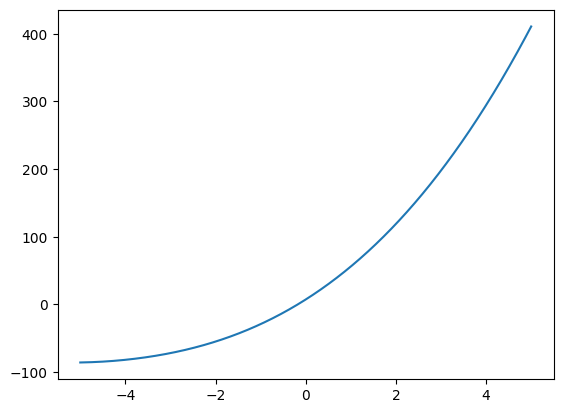

In [4]:
from __future__ import division, print_function
import cocoex, cocopp  # experimentation and post-processing modules
import scipy.optimize  # to define the solver to be benchmarked
from numpy.random import rand  # for randomised restarts
import os, webbrowser  # to show post-processed results in the browser
from typing import Tuple
import matplotlib.pyplot as plt
%matplotlib inline

class COCO(DynamicalSystem):
    def __init__(self, 
                 index: int,  # index of the problem in the suite to use
                 u_index: int,  # index of which coordinate of the problem we will optimize
                ):
        suite_name = "bbob"
        suite = cocoex.Suite(suite_name, "", "")
        self.problem = suite[index]
        self.u_index = u_index
        self.x = self.problem.initial_solution_proposal()  # fixed init
#         self.x = self.problem.lower_bounds + np.random.rand(self.problem.dimension) * (problem.upper_bounds - problem.lower_bounds  # random init
        self.interval = (self.problem.lower_bounds[u_index], self.problem.upper_bounds[u_index])
        
#         # for prettiness
#         output_folder = "gpc"
#         observer = cocoex.Observer(suite_name, "result_folder: " + output_folder)
#         self.problem.observe_with(observer)  # generates the data for cocopp post-processing
#         minimal_print = cocoex.utilities.MiniPrint()
#         budget_multiplier = 1  # increase to 10, 100, ...
        pass
    
    def get_init(self) -> Tuple[float, Tuple[float, float]]:  # returns initial value and desired interval
        return self.x[self.u_index], self.interval
        
    def interact(self, control: float):
        assert control >= self.interval[0] and control <= self.interval[1], 'control must be in {}'.format(self.interval)
        x = self.x.copy()
        x[self.u_index] = control
        return self.problem(x)
    
    def is_done(self):
        return problem.final_target_hit
        
#     ### post-process data
#     cocopp.main(observer.result_folder)  # re-run folders look like "...-001" etc
#     webbrowser.open("file://" + os.getcwd() + "/ppdata/index.html")

c = COCO(200, 0)
x = np.linspace(-5, 5, 10000)
vals = [c.interact(xi) for xi in x]
plt.plot(x, vals)
plt.show()

initial=0.0    interval=(-5.0, 5.0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4211.58it/s]


Text(0.5, 1.0, 'f vs u')

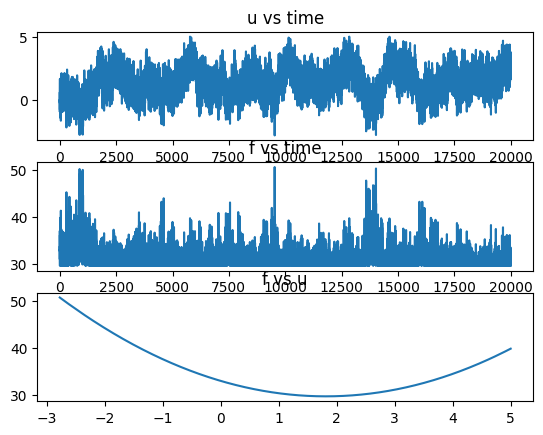

In [15]:
from hyperparameter import FloatHyperparameter
import tqdm

problem_idx = np.random.randint(2000)
n_iters = 20000
n_trials = 5

c = COCO(problem_idx, 1)
initial_value, interval = c.get_init()
print('initial={}    interval={}'.format(initial_value, interval))
args = {
        'h': 20,
        'initial_value': initial_value,
        'interval': interval,
        'rescale': True,
        'quadratic_term': 0,
#         'w_clip_size': 0.01,
#         'M_clip_size': 1e-9,
        # 'B_clip_size': 1,  
        # 'update_clip_size': 1,                                
        # 'cost_clip_size': 1,
        'method': 'REINFORCE',
    }    
controller = FloatHyperparameter(**args)

us = []
fs = []
for _ in tqdm.trange(n_iters):
    u = controller.get_value()
    u = np.clip(u, *interval)
    f = c.interact(u)
    us.append(u)
    fs.append(f)
    controller.step(obj=f)
us = np.array(us)
fs = np.array(fs)

import matplotlib.pyplot as plt
%matplotlib inline

# from testing.utils import window_average
# window_size = n_iters // 200
# us = window_average(us, window_size)
# fs = window_average(fs, window_size)

fig, ax = plt.subplots(3, 1)
ax[0].plot(range(len(us)), us)
ax[0].set_title('u vs time')

ax[1].plot(range(len(fs)), fs)
ax[1].set_title('f vs time')

idxs = np.argsort(us)
ax[2].plot(us[idxs], fs[idxs])
ax[2].set_title('f vs u');